In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from Bio.Data import CodonTable
from Bio.Restriction.Restriction_Dictionary import rest_dict
from Bio import Restriction
import tqdm
from Bio.Seq import Seq
from Bio.Restriction import Analysis, AllEnzymes

In [10]:
codontable = CodonTable.ambiguous_dna_by_id[1]
possible_nucls = codontable.nucleotide_alphabet + "-"
nucls = list("ACGT")
possible_nucls, nucls

('GATCRYWSMKHBVDN-', ['A', 'C', 'G', 'T'])

In [3]:
PATH_TO_MULAL = "../data/interim/mulal.fasta"

### Generate table summarizing genomes site states

In [64]:
fasta = SeqIO.parse(PATH_TO_MULAL, "fasta")
ref_rec = next(fasta)
base_dct = {nucl: 0 for nucl in possible_nucls}
data = [base_dct.copy() for _ in range(len(ref_rec.seq))]
for i, nucl in enumerate(str(ref_rec.seq)):
    data[i][nucl] += 1

for rec in tqdm.tqdm(fasta, "Seqs", 56446):
    seq = str(rec.seq)
    for i, nucl in enumerate(seq):
        data[i][nucl] += 1


Seqs: 100%|█████████▉| 56445/56446 [02:04<00:00, 454.60it/s]


In [ ]:
df = pd.DataFrame(data)
df.reset_index(inplace=True)
df.rename(columns={"index": "Pos"}, inplace=True)
df["Pos"] += 1
df.to_csv("../data/share/genomes_summary.tsv", sep="\t", index=None)
df.tail()

In [69]:
df = pd.read_csv("../data/share/genomes_summary.tsv", sep="\t")

### Need to find site, that do only cut on sequence

In [70]:
df["Stability"] = df.drop("Pos", axis=1).max(axis=1) / df.iloc[0, 1:].sum()
df

,Pos,G,A,T,C,R,Y,W,S,M,K,H,B,V,D,N,-,Stability
0,1,55139,0,2,2,0,0,0,0,0,0,0,0,0,0,77,1226,0.976845
1,2,1,55250,1,0,0,0,0,0,0,0,0,0,0,0,49,1145,0.978812
2,3,0,1,55267,23,0,0,0,0,0,0,0,0,0,0,50,1105,0.979113
3,4,3,2,3,55307,0,0,0,0,0,0,0,0,0,0,45,1086,0.979821
4,5,1,55317,2,14,0,0,0,0,0,0,0,0,0,0,44,1068,0.979999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16564,16565,0,1,0,55313,0,0,0,0,0,0,0,0,0,0,53,1079,0.979928
16565,16566,55267,16,0,0,0,0,0,0,0,0,0,0,0,0,58,1105,0.979113
16566,16567,0,55265,0,1,0,0,0,0,0,0,0,0,0,0,54,1126,0.979077
16567,16568,0,2,55207,7,0,0,0,0,0,0,0,0,0,0,58,1172,0.978050


In [85]:
df_const = df[
    (df["-"] == 0) &
    (df.Stability > 0.999) &
    (df[nucls].sum(axis=1) == df[nucls].max(axis=1))  # interesting condition
]
print(df_const.shape)
df_const.head(10)

(5348, 18)


,Pos,G,A,T,C,R,Y,W,S,M,K,H,B,V,D,N,-,Stability
579,580,0,0,56440,0,0,0,0,0,0,0,0,0,0,0,6,0,0.999894
580,581,0,56439,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0.999876
581,582,0,0,56443,0,0,0,0,0,0,0,0,0,0,0,3,0,0.999947
582,583,56442,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0.999929
585,586,56443,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0.999947
588,589,0,0,56443,0,0,0,0,0,0,0,0,0,0,0,3,0,0.999947
589,590,0,56444,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0.999965
597,598,0,56445,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.999982
598,599,0,56445,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.999982
599,600,0,56445,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.999982


### Extract fully constant sequences

In [86]:
prev = -10
x = df_const.Pos.values
cur_pos_set = set()
colection_of_sequential = []
for i in range(x.shape[0] - 1):
    if x[i] + 1 == x[i + 1]:
        cur_pos_set.add(x[i])
        cur_pos_set.add(x[i + 1])
    else:
        if len(cur_pos_set) > 3:
            colection_of_sequential.append(sorted(cur_pos_set))
        cur_pos_set = set()

colection_of_sequential[:2]

[[580, 581, 582, 583], [598, 599, 600, 601, 602]]

In [87]:
potential_sites = []
for sequential in colection_of_sequential:
    da = df_const[df_const.Pos.isin(sequential)][nucls]
    _pos = da.values.argmax(axis=1)
    seq = "".join([nucls[i] for i in _pos])
    potential_sites.append(seq)

potential_sites[:5]

['TATG', 'AAAGC', 'TGAA', 'ACGGG', 'CCCCAT']

In [88]:
enzymes = AllEnzymes.copy()


def extract_restr_enz(seq: Seq, enzymes=enzymes, linear=True) -> list:
    anal = Analysis(enzymes, seq, linear=linear)
    pot_rs = []
    for restr_enz, positions in anal.with_N_sites(1).items():
        pos = positions[0]
        re_name = repr(restr_enz)
        site = restr_enz.site

        one_data = {
            "RE": re_name,
            "Site": site,
            "CutPos": pos,
        }
        pot_rs.append(one_data)
    return pot_rs

In [89]:
data = []
for seq_str, indexes in zip(potential_sites, colection_of_sequential):
    seq = Seq(seq_str)
    cur_data = extract_restr_enz(seq)
    for re in cur_data:
        re["seq"] = seq_str
        re["start_idx"] = indexes[0]
        data.append(re)
len(data)

377

In [90]:
df_re = pd.DataFrame(data)
df_re.head()

,RE,Site,CutPos,seq,start_idx
0,BmeDI,C,4,TATG,580
1,FaiI,YATR,3,TATG,580
2,BmeDI,C,4,AAAGC,598
3,RlaI,VCW,3,AAAGC,598
4,BmeDI,C,2,TGAA,610


### Need only ONE CUT
every RE must be checked on consensus cutting only one time

In [94]:
... # TODO add filtration of RE to exclude RE that cut more that 1 time

Ellipsis

In [91]:
df_re.to_csv("../data/processed/re_by_aln.tsv", sep="\t", index=None)

#### It works:
```
$ cut -f 1 data/processed/re_by_aln.tsv > /tmp/f.txt
$ grep -f /tmp/f.txt data/share/cuted_seqs_num.csv 
RE,CuttedSeqs
TaqII,55615  # -> only suitable re
PspOMII,487
Kor51II,57
Cfr42I,22
SacII,22
KspI,22
SgrBI,22
Sfr303I,22
AccIII,1
```

But on fully conservative sites there are only one RE 'TaqII' that cut all sequences (stupid method show, that it effectivity is 55615 times, but in some seqs some nucleotides are uncertain)

## Run stupid script here

In [61]:
import random
from collections import Counter
from multiprocessing import Pool

import pandas as pd
from Bio.Restriction import Analysis, AllEnzymes
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
import tqdm

PATH_TO_SEQS = "../data/raw/sequence.fasta"
THREADS = 24

fasta = SeqIO.parse(PATH_TO_SEQS, "fasta")
enzymes = AllEnzymes.copy()


def cleanup_enzymes(prob=0.01):
    """don't do it"""
    fasta = SeqIO.parse(PATH_TO_SEQS, "fasta")
    n = 0
    pot_rs = []
    for rec in tqdm.tqdm(fasta, "Seqs", 56446):
        if random.random() > prob:
            continue
        n += 1
        anal = Analysis(enzymes, rec.seq, linear=False)
        anal.mapping # dict[RS_name, positions]
        
        for rest_enz, positions in anal.mapping.items():
            if len(positions) == 1:
                pot_rs.append(rest_enz)

    ctr = Counter(pot_rs)
    m = 0
    for enz, amount in ctr.items():
        if amount != n:
            if enz in enzymes:
                enzymes.remove(enz)
                m += 1
    print(f"Removed {m} enzymes")
    

def extract_restr_enz(rec: SeqRecord) -> list:
    anal = Analysis(enzymes, rec.seq, linear=False)
    anal = Analysis(enzymes, rec.seq, linear=False)
    pot_rs = []
    for restr_enz, positions in anal.with_N_sites(1).items():
        pos = positions[0]
        re_name = repr(restr_enz)
        site = restr_enz.site

        one_data = {
            "RE": re_name,
            "Site": site,
            "SeqName": rec.description,
            "CutPos": pos,
        }
        pot_rs.append(one_data)
    return pot_rs

In [66]:
rec = next(fasta)
pd.DataFrame(extract_restr_enz(rec))

,RE,Site,SeqName,CutPos
0,BmtI,GCTAGC,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...,4588
1,NmeA6CIII,GCCGAC,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...,5940
2,RceI,CATCGAC,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...,14830
3,Eco47III,AGCGCT,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...,4535
4,NgoMIV,GCCGGC,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...,935
...,...,...,...,...
96,AsuNHI,GCTAGC,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...,4584
97,BbvCI,CCTCAGC,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...,13042
98,PsuI,RGATCY,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...,14262
99,BbsI,GAAGAC,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...,2733


In [62]:
len(enzymes), len(AllEnzymes)

(978, 978)

In [67]:
# 23 min or 54 min
fasta = SeqIO.parse(PATH_TO_SEQS, "fasta")
with Pool(THREADS) as p:
    collection_of_pot_rs = p.map(extract_restr_enz, fasta)

In [68]:
pot_rs = []
for xx in collection_of_pot_rs:
    for x in xx:
        pot_rs.append(x)  

In [69]:
df = pd.DataFrame(pot_rs)

In [70]:
# df.to_csv("../data/processed/re.csv", index=None)

In [5]:
df = pd.read_csv("../data/processed/re.csv")
df.head()

,RE,Site,SeqName,CutPos
0,BmtI,GCTAGC,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...,4588
1,NmeA6CIII,GCCGAC,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...,5940
2,RceI,CATCGAC,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...,14830
3,Eco47III,AGCGCT,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...,4535
4,NgoMIV,GCCGGC,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...,935


In [6]:
df_counts = df.RE.value_counts().reset_index()
df_counts.columns = ["RE", "CuttedSeqs"]
# df_counts.to_csv("../data/share/cuted_seqs_num.csv", index=None)

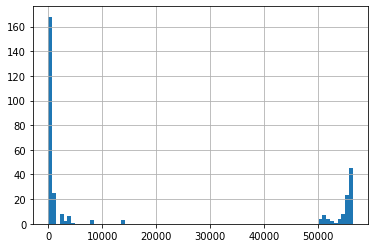

In [8]:
df.RE.value_counts().hist(bins=80);

In [9]:
df_counts

,RE,CuttedSeqs
0,BspDI,56384
1,BseCI,56384
2,Bsa29I,56384
3,Bsu15I,56384
4,BshVI,56384
...,...,...
309,Nal45188II,1
310,PpuMI,1
311,PspPPI,1
312,BssNAI,1


In [18]:
freq_re = df_counts[df_counts.CuttedSeqs > 55000].RE.values
freq_re.shape

(68,)

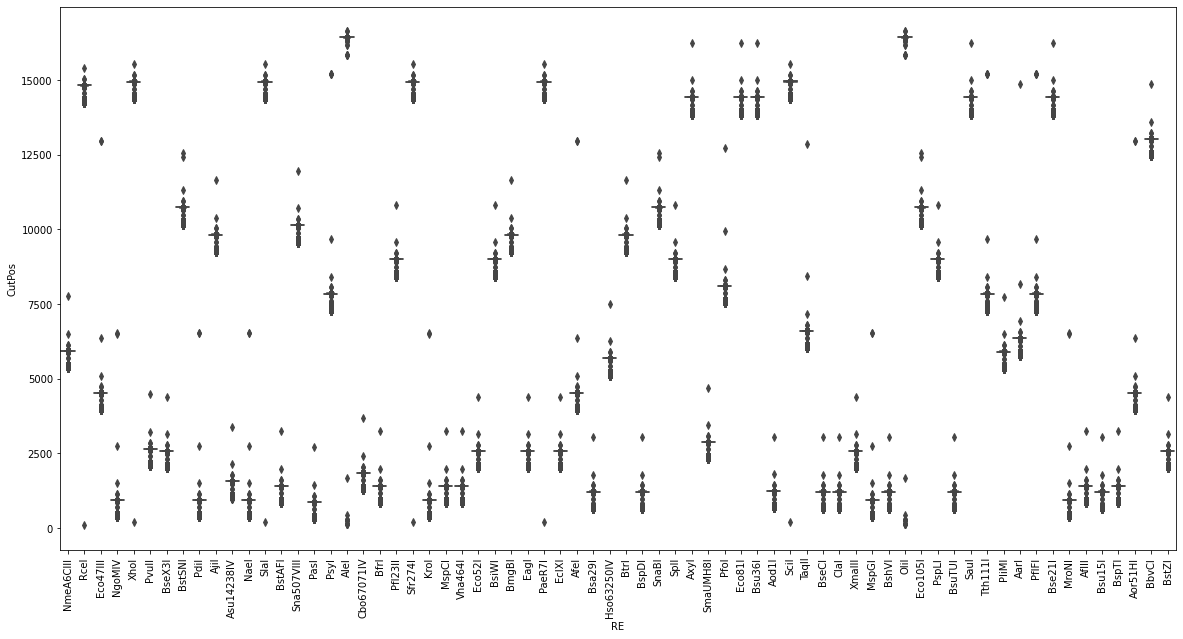

In [25]:
plt.figure(figsize=(20, 10))
sns.boxplot(x="RE", y="CutPos", data=df[df.RE.isin(freq_re)])
plt.xticks(rotation=90)
plt.show()